# Face Detection

Hello! In this task you will create your own deep face detector.

First of all, we need import some useful stuff.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Do you have modern Nvidia [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit)? There is your video-card model in [list](https://developer.nvidia.com/cuda-gpus) and CUDA capability >= 3.0?

- Yes. You can use it for fast deep learning! In this work we recommend you use tensorflow backend with GPU. Read [installation notes](https://www.tensorflow.org/install/) with attention to gpu section, install all requirements and then install GPU version `tensorflow-gpu`.
- No. CPU is enough for this task, but you have to use only simple model. Read [installation notes](https://www.tensorflow.org/install/) and install CPU version `tensorflow`.

Of course, also you should install `keras`, `matplotlib`, `numpy` and `scikit-image`.

In [2]:
from keras import backend as K

Using TensorFlow backend.


In [3]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import transform
import cv2

In [4]:
from get_data import load_dataset, unpack

In this task we use processed [FDDB dataset](http://vis-www.cs.umass.edu/fddb/). Processing defined in file [./prepare_data.ipynb](prepare_data.ipynb) and consists of:

1. Extract bboxes from dataset. In base dataset face defined by [ellipsis](http://vis-www.cs.umass.edu/fddb/samples/) that not very useful for basic neural network learning.
2. Remove images with big and small faces on one shoot.
3. Re-size images to bounding boxes (bboxes) have same size 32 +/- pixels.

Each image in train, validation and test datasets have shape (176, 176, 3), but part of this image is black background. Interesting image aligned at top left corner.

Bounding boxes define face in image and consist of 7 integer numbers: [image_index, min_row, min_col, max_row, max_col]. Bounding box width and height are 32 +/- 8 pixels wide.

`train_bboxes` and `val_bboxes` is a list of bboxes.

`train_shapes` and `val_shapes` is a list of interesting image shapes.

In [5]:
# First run will download 30 MB data from github

train_images, train_bboxes, train_shapes = load_dataset("train")
val_images, val_bboxes, val_shapes = load_dataset("val")

## Prepare data (1 point)

Visualize first image from train dataset with face bounding box rectangle. Note that true shape of image is stored in another array.

In [9]:
# check that train_bboxes is sorted by image index
current_image_idx = 0
is_sorted = True
for image_idx, _, _, _, _ in train_bboxes:
    if current_image_idx == image_idx or current_image_idx == image_idx - 1:
        current_image_idx = image_idx
    else:
        is_sorted = False
        break
print('Sorted' if is_sorted else 'Not sorted')

Sorted


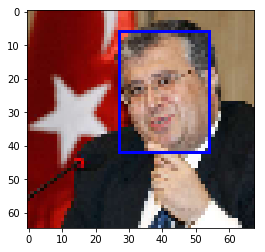

In [6]:
image_idx = 0
image = train_images[image_idx].copy()
for idx, min_row, min_col, max_row, max_col in train_bboxes:
    if idx == image_idx:
        image = cv2.rectangle(image,
                              (min_col, min_row),
                              (max_col, max_row),
                              (0, 0, 255),
                              1)
plt.imshow(image[0:train_shapes[0, 0], 0:train_shapes[0, 1], :])

For learning we should extract positive and negative samples from image.
Positive and negative samples counts should be similar.
Every samples should have same size.
Positive sample is actual face resized to target shape, negative one should is some cropped not face region also resized to target shape

In [7]:
SAMPLE_SHAPE = (32, 32, 3)

Use this function to detect that your negative bounding box is not a face

In [8]:
from scores import iou_score  # https://en.wikipedia.org/wiki/Jaccard_index


def is_negative_bbox(new_bbox, true_bboxes, eps=1e-1):
    """There bbox is 4 ints [min_row, min_col, max_row, max_col] without image index."""
    for bbox in true_bboxes:
        if iou_score(new_bbox, bbox) >= eps:
            return False
    return True

In [42]:
def get_positive_negative(images, true_bboxes, image_shapes):
    """Retrieve positive and negative samples from image."""
    positive = []
    negative = []
    
    # Pay attention to the fact that most part of image may be black -
    # extract negative samples only from part [0:image_shape[0], 0:image_shape[1]]
    
    true_bboxes_finish = 0
    for image_idx, image in enumerate(images):
        true_bboxes_start = true_bboxes_finish
        while true_bboxes_finish + 1 < len(true_bboxes):
            true_bboxes_finish += 1
            if true_bboxes[true_bboxes_finish, 0] != true_bboxes[true_bboxes_start, 0]:
                break
        true_bboxes_count = true_bboxes_finish - true_bboxes_start
        positive.extend([cv2.resize(image[min_row:max_row, min_col:max_col, :], SAMPLE_SHAPE[:-1])
                         for _, min_row, min_col, max_row, max_col in true_bboxes[true_bboxes_start:true_bboxes_finish]])

        negative_new = []
        true_bboxes_of_image = [bbox[1:] for bbox in true_bboxes[true_bboxes_start:true_bboxes_finish]]
        while len(negative_new) < true_bboxes_count:
            crop_size = np.random.randint(8, 33)
            if is_negative_bbox((0, 0, crop_size, crop_size), true_bboxes_of_image):
                crop = image[0:crop_size, 0:crop_size]
                negative_new.append(cv2.resize(crop, SAMPLE_SHAPE[:-1]))
        negative.extend(negative_new)
    assert len(positive) == len(negative), 'Number of negative and positive samples differ'
    return positive, negative

In [44]:
def get_samples(images, true_bboxes, image_shapes):
    """Usefull samples for learning.
    
    X - positive and negative samples.
    Y - one hot encoded list of zeros and ones. One is positive marker.
    """
    positive, negative = get_positive_negative(images=images, true_bboxes=true_bboxes, 
                                               image_shapes=image_shapes)
    X = positive
    Y = [[0, 1] for _ in range(len(positive))]
    
    X.extend(negative)
    Y.extend([[1, 0] for _ in range(len(negative))])
    
    return np.array(X), np.array(Y)

Now we can extract samples from images.

In [45]:
X_train, Y_train = get_samples(train_images, train_bboxes, train_shapes)
X_val, Y_val = get_samples(val_images, val_bboxes, val_shapes)

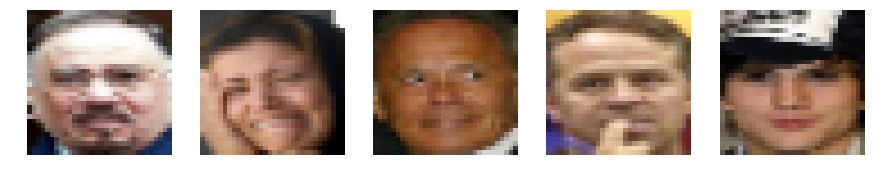

In [46]:
# There we should see faces
from graph import visualize_samples
visualize_samples(X_train[Y_train[:, 1] == 1])

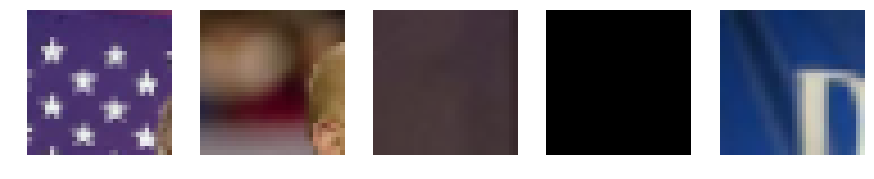

In [47]:
# There we shouldn't see faces
visualize_samples(X_train[Y_train[:, 1] == 0])

## Classifier training (3 points)

First of all, we should train face classifier that checks if face represented on sample.

In [ ]:
BATCH_SIZE = 64

### Image augmentation

Important thing in deep learning is augmentation. Sometimes, if your model are complex and cool, you can increase quality by using good augmentation.

Keras provide good [images preprocessing and augmentation](https://keras.io/preprocessing/image/). This preprocessing executes online (on the fly) while learning.

Of course, if you want using samplewise and featurewise center and std normalization you should run this transformation on predict stage. But you will use this classifier to fully convolution detector, in this case such transformation quite complicated, and we don't recommend use them in classifier.

For heavy augmentation you can use library [imgaug](https://github.com/aleju/imgaug). If you need, you can use this library in offline manner (simple way) and online manner (hard way). However, hard way is not so hard: you only have to write [python generator](https://wiki.python.org/moin/Generators), which returns image batches, and pass it to [fit_generator](https://keras.io/models/model/#fit_generator)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator # Usefull thing. Read the doc.

datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.1,
                            )
datagen.fit(X_train)

### Fitting classifier

For fitting you can use one of Keras optimizer algorithms. [Good overview](http://ruder.io/optimizing-gradient-descent/)

To choose best learning rate strategy you should read about EarlyStopping and ReduceLROnPlateau or LearningRateScheduler on [callbacks](https://keras.io/callbacks/) page of keras documentation, it's very useful in deep learning.

If you repeat architecture from some paper, you can find information about good optimizer algorithm and learning rate strategy in this paper. For example, every [keras application](https://keras.io/applications/) has link to paper, that describes suitable learning procedure for this specific architecture.

In [ ]:
from keras.optimizers import RMSprop
# Very usefull, pay attention
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from graph import plot_history

def fit(model_name, model, datagen, X_train, Y_train, X_val, Y_val, class_weight=None, epochs=10, lr=0.001, verbose=False):
    """Fit model.
    
    You can edit this function anyhow.
    """
    
    if verbose:
        model.summary()

    model.compile(optimizer=RMSprop(lr=lr), # You can use another optimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                                  validation_data=(X_val, Y_val),
                                  epochs=epochs, steps_per_epoch=len(X_train) // BATCH_SIZE,
                                  callbacks=[
                                        # May lead to crash on windows. Uncomment and try, it may work for you
                                        #ModelCheckpoint(model_name + "-{epoch:02d}-{val_loss:.2f}.hdf5", save_best_only=True)
                                    ]
                                 )  # starts training
    
    plot_history(history)

#### (first point out of three)

We propose you make your own classification model based on lenet architecture.

![lenet architecture](lenet_architecture.png)
LeCun, Y., Bottou, L., Bengio, Y. and Haffner, P., 1998. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), pp.2278-2324.

Of course, you can use any another architecture, if want. Main thing is classification quality of your model.

Acceptable validation accuracy for this task is 0.92.

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Input, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

# Classification model
# You can start from LeNet architecture

x = inputs = Input(shape=SAMPLE_SHAPE)

# Insert your architecture here

# This creates a model
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

#### Fit the model (second point out of three)

If you doesn't have fast video-card suitable for deep learning, you can first check neural network modifications with small value of parameter `epochs`, for example, 10, and then after selecting best model increase this parameter.
Fitting on CPU can be long, we suggest do it at bedtime.

Don't forget change model name.

In [ ]:
fit(model_name="baseline", epochs=50, model=model, datagen=datagen, X_train=X_train, X_val=X_val, Y_train=Y_train, Y_val=Y_val)

#### (third point out of three)

After learning model weights saves in folder `data/checkpoints/`.
Use `model.load_weights(fname)` to load best weights.

In [ ]:
# model.load_weights("data/checkpoints/...")

## Detection

If you have prepared classification architecture with high validation score, you can use this architecture for detection.

Convert classification architecture to fully convolution neural network (FCNN), that returns heatmap of activation.

### Detector model or sliding window (1 point)

Now you should replace fully-connected layers with $1 \times 1$ convolution layers.

Every fully connected layer perform operation $f(Wx + b)$, where $f(\cdot)$ is nonlinear activation function, $x$ is layer input, $W$ and $b$ is layer weights. This operation can be emulated with $1 \times 1$ convolution with activation function $f(\cdot)$, that perform exactly same operation $f(Wx + b)$.

If there is `Flatten` layer with $n \times k$ input size before fully connected layers, convolution should have same $n \times k$ input size.
Multiple fully connected layers can be replaced with convolution layers sequence.

After replace all fully connected layers with convolution layers, we get fully convolution network. If input shape is equal to input size of previous network, output will have size $1 \times 1$. But if we increase input shape, output shape automatically will be increased. For example, if convolution step of previous network strides 4 pixels, increase input size with 100 pixels along all axis makes increase output size with 25 values along all axis. We got activation map of classifier without necessary extract samples from image and multiple calculate low-level features.

In total:
1. $1 \times 1$ convolution layer is equivalent of fully connected layer.
2. $1 \times 1$ convolution layers can be used to get activation map of classification network in "sliding window" manner.

We propose replace last fully connected layer with two outputs and softmax activation function with one convolution and ReLU activation. This configuration useful to find local maximum of activation map.

#### Example of replace cnn head:

##### Head before convert

![before replace image](before_convert.png)

##### Head after convert

![before replace image](after_convert.png)

On this images displayed only head. `InputLayer` should be replaced with convolution part exit.
Before convert network head takes fifty $8 \times 8$ feature maps and returns two values: probability of negative and positive classes. This output can be considered as activation map with size $1 \times 1$.

If input have size $8 \times 8$, output after convert would have $1 \times 1$ size, but input size is $44 \times 44$.
After convert network head returns one $37 \times 37$ activation map.

In [ ]:
# FCNN

IMAGE_SHAPE = (176, 176, 3)

def generate_fcnn_model(image_shape):
    """After model compilation input size cannot be changed.
    
    So, we need create a function to have ability to change size later.
    """
    x = inputs = Input(shape=image_shape)

    # Write code here
    # ...

    # This creates a model
    predictions = Conv2D(1, (1, 1), activation='relu')(x)
    return Model(inputs=inputs, outputs=predictions)

fcnn_model = generate_fcnn_model(IMAGE_SHAPE)

#### (1 point)

Then you should write function that copy weights from classification model to fully convolution model.
Convolution weights may be copied without modification, fully-connected layer weights should be reshaped before copy.

Pay attention to last layer.

In [ ]:
def copy_weights(base_model, fcnn_model):
    """Set FCNN weights from base model.
    """
    
    new_fcnn_weights = []
    prev_fcnn_weights = fcnn_model.get_weights()
    prev_base_weights = base_model.get_weights()
    
    # Write code here
    # ...
        
    fcnn_model.set_weights(new_fcnn_weights)

copy_weights(base_model=model, fcnn_model=fcnn_model)

### Model visualization

In [ ]:
from graph import visualize_heatmap

In [ ]:
predictions = fcnn_model.predict(np.array(val_images))
visualize_heatmap(val_images, predictions[:, :, :, 0])

### Detector (1 point)

First detector part is getting bboxes and decision function.
Greater decision function indicates better detector confidence. 

Now you need to be a little creative and implement some logic: how heatmaps will be transformed to bounding boxes. In you fcnn_model output you have heatmap of some size. You need to understand how heatmap coordinates (predictions) correlate with detecting image on the source. For example, if your model uses two poolings you need to multiply coordinates by 4.
After that you need to get the biggest signals for most certain locations of face. Hint: peak_local_max function can be useful.
Note also that evaluation process will pick the best face you detected near real one and all others will be false positives. So to improve your score you better choose just one (maybe best) face in a region of local max activations. You can also use any clusterization mechanism or non-maximum suppression technique.

In [ ]:
# Detection
from skimage.feature import peak_local_max

def get_bboxes_and_decision_function(fcnn_model, images, image_shapes):
    cropped_images = np.array([transform.resize(image, IMAGE_SHAPE, mode="reflect") for image in images])
    pred_bboxes, decision_function = [], []
   
    # Predict
    predictions = fcnn_model.predict(cropped_images)

    # Write code here
    # ...
        
    return pred_bboxes, decision_function

#### Detector visualization

In [ ]:
from graph import visualize_bboxes

In [ ]:
pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

## Detector score (1 point)

Write [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) graph.

You can use function `best_match` to extract matching between prediction and ground truth, false positive and false negative samples. Pseudo-code for calculation precision and recall graph:
    
    # Initialization for first step threshold = -inf
    tp, fp := 0, 0 # We haven't any positive sample
    fn := |true_bboxes| # All true bboxes haven't been caught
    tn := |false_positive| # But also all false positives samples haven't been caught if threshold = -inf
    
    Sort pred_bboxes with order defined by decision_function
    y_true := List of answers for "Is the bbox have matching in y_true?" for every bbox in pred_bboxes
    
    for y_on_this_step in y_true:
        # Now we increase threshold, so some predicted bboxes makes positive.
        # If y_t is True then the bbox is true positive else bbox is false positive
        # So we should
        Update tp, tn, fp, fn with attention to y_on_this_step
        
        Add precision and recall point calculated by formula through tp, tn, fp, fn on this step

In [ ]:
from scores import best_match
from graph import plot_precision_recall

def precision_recall_curve(pred_bboxes, true_bboxes, decision_function):
    precision, recall = [], []
    
    # Write code here
    # ...
    
    return precision, recall

In [ ]:
precision, recall = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

### Threshold (1 point)

Next step in detector creating is select threshold for decision_function.
Every possible threshold presents point on recall-precision graph.

Select threshold for `recall=0.85`.

In [ ]:
THRESHOLD = 5.9

def detect(fcnn_model, images, image_shapes, threshold=THRESHOLD, return_decision=True):
    """Get bboxes with decision_function not less then threshold."""
    pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model, images, image_shapes)   
    result, result_decision = [], []
    
    # Write code here
    # ...
    
    if return_decision:
        return result, result_decision
    else:
        return result

In [ ]:
pred_bboxes, decision_function = detect(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes, return_decision=True)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

precision, recall = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

## Test dataset (1 point)

Last detector preparation step is testing.

Attention: to avoid over-fitting, after testing algorithm you should run [./prepare_data.ipynb](prepare_data.ipynb), and start all fitting from beginning.

Detection score (in graph header) should be 0.75 or greater.

In [ ]:
test_images, test_bboxes, test_shapes = load_dataset("test")
pred_bboxes, decision_function = detect(fcnn_model=fcnn_model, images=test_images, image_shapes=test_shapes, return_decision=True)
visualize_bboxes(images=test_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=test_bboxes,
                 decision_function=decision_function
                )

precision, recall = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=test_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

## Optional tasks

### Real image dataset

Test your algorithm on original (not scaled) data.
Visualize bboxes and plot precision-recall curve.

In [ ]:
# First run will download 523 MB data from github

original_images, original_bboxes, original_shapes = load_dataset("original")

In [ ]:
# Write code here
# ...

## Hard negative mining

Upgrade the score with hard negative mining.

In [ ]:
def hard_negative(train_images, image_shapes, train_bboxes, X_val, Y_val, base_model, fcnn_model):
    pass

In [ ]:
hard_negative(train_images=train_images, image_shapes=train_shapes, train_bboxes=train_bboxes, X_val=X_val, Y_val=Y_val, base_model=model, fcnn_model=fcnn_model)

In [ ]:
# model.load_weights("data/checkpoints/...")

In [ ]:
copy_weights(base_model=model, fcnn_model=fcnn_model)

pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

precision, recall = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

### Multi scale detector

Write and test detector with [pyramid representation][pyramid].
[pyramid]: https://en.wikipedia.org/wiki/Pyramid_(image_processing)

In [ ]:
def multiscale_detector(fcnn_model, images, image_shapes):
    pass

### Next  step

Next steps in deep learning detection are R-CNN, Faster R-CNN and SSD architectures.
This architecture realization is quite complex.
For this reason the task doesn't cover them, but you can find the articles in the internet.